## Explore data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import os

#chanhe this manualy
path = '/media/roman/Main/Programing/contest/dmc2017/dmc-2017/'
os.chdir(path)

In [2]:
items = pd.read_csv('data/raw/items.csv',sep='|')
train = pd.read_csv('data/raw/train.csv',sep='|')

In [3]:
train.head(5)

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14


In [4]:
items.head(5)

,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
1,2,1,2FOI,80,ST,Tab,0,40,NaN,NaN,10.89
2,3,1,2FOI,10,G,GLO,0,40,NaN,NaN,16.45
3,4,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
4,5,2,10OJ03JS,8,ST,PUL,0,40,1.0,NaN,22.53


In [5]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756003 entries, 0 to 2756002
Data columns (total 11 columns):
lineID             2756003 non-null int64
day                2756003 non-null int64
pid                2756003 non-null int64
adFlag             2756003 non-null int64
availability       2756003 non-null int64
competitorPrice    2655316 non-null float64
click              2756003 non-null int64
basket             2756003 non-null int64
order              2756003 non-null int64
price              2756003 non-null float64
revenue            2756003 non-null float64
dtypes: float64(3), int64(8)
memory usage: 231.3 MB


In [6]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22035 entries, 0 to 22034
Data columns (total 11 columns):
pid               22035 non-null int64
manufacturer      22035 non-null int64
group             22035 non-null object
content           22035 non-null object
unit              22035 non-null object
pharmForm         19708 non-null object
genericProduct    22035 non-null int64
salesIndex        22035 non-null int64
category          17408 non-null float64
campaignIndex     1338 non-null object
rrp               22035 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.8+ MB


In [7]:
train_items=pd.merge(train,items,on='pid')
del train
gc.collect

<function gc.collect>

## Preprocessing

In [8]:
def toCategorical(df):
    columns=['availability','group','content','unit','pharmForm',
             'campaignIndex','salesIndex', 'category', 'manufacturer']
    for col in columns:
        if col in df.columns:
            df[col]=df[col].astype('category')
    return df

In [9]:
train_items=toCategorical(train_items)

In [10]:
t1=train_items['rrp'].as_matrix()
t2=train_items['competitorPrice'].as_matrix()
t2_div_t1=t2/t1
t2_div_t1=t2_div_t1[np.logical_not(np.isnan(t2_div_t1))]
coef_competitorPrice_to_rrp=t2_div_t1.mean()
print coef_competitorPrice_to_rrp

0.713654175692


In [11]:
def solveNA(df,df2,coef,flag):
    if flag==1:  
        df['pharmForm'] = df['pharmForm'].fillna('no_pharmForm')   
        df['category'] = df['category'].fillna(410)
        df['campaignIndex'] = df['campaignIndex'].fillna('D')
    else:  
        df['competitorPrice'] = df['competitorPrice'].fillna(df2['rrp']*coef)
        if 'pharmForm' in df.columns:
            df['pharmForm'] = df['pharmForm'].cat.add_categories(['no_pharmForm'])
            df['pharmForm'] = df['pharmForm'].fillna('no_pharmForm')
        if 'category' in df.columns:
            df['category'] = df['category'].cat.add_categories([410])
            df['category'] = df['category'].fillna(410)
        if 'campaignIndex' in df.columns:
            df['campaignIndex'] = df['campaignIndex'].cat.add_categories(['D'])
            df['campaignIndex'] = df['campaignIndex'].fillna('D')
    columns2=['category', 'manufacturer']
    for col2 in columns2:
        if col2 in df.columns:
            df[col2]=df[col2].astype('int')
            df[col2]=df[col2].astype('category')
    return df

In [12]:
items=solveNA(items,train_items,coef_competitorPrice_to_rrp,1)
train_items=solveNA(train_items,train_items,coef_competitorPrice_to_rrp,0)

In [13]:
train_items.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2756003 entries, 0 to 2756002
Data columns (total 21 columns):
lineID             2756003 non-null int64
day                2756003 non-null int64
pid                2756003 non-null int64
adFlag             2756003 non-null int64
availability       2756003 non-null category
competitorPrice    2756003 non-null float64
click              2756003 non-null int64
basket             2756003 non-null int64
order              2756003 non-null int64
price              2756003 non-null float64
revenue            2756003 non-null float64
manufacturer       2756003 non-null category
group              2756003 non-null category
content            2756003 non-null category
unit               2756003 non-null category
pharmForm          2756003 non-null category
genericProduct     2756003 non-null int64
salesIndex         2756003 non-null category
category           2756003 non-null category
campaignIndex      2756003 non-null category
rrp           

In [14]:
def Dummies(df):
    columns=['availability','unit','salesIndex','campaignIndex']
    dumm=pd.get_dummies(df[columns])
    df=pd.concat([df, dumm], axis=1)
    return df

In [15]:
train_items=Dummies(train_items)

In [16]:
def moreFeautures(df):
    df['day_of_week']=df['day']%7
    df['discount']=df['price']/df['rrp']
    df['compDiscount']=df['competitorPrice']/df['price']
    return df

In [17]:
train_items=moreFeautures(train_items)

In [18]:
train_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2756003 entries, 0 to 2756002
Data columns (total 44 columns):
lineID             int64
day                int64
pid                int64
adFlag             int64
availability       category
competitorPrice    float64
click              int64
basket             int64
order              int64
price              float64
revenue            float64
manufacturer       category
group              category
content            category
unit               category
pharmForm          category
genericProduct     int64
salesIndex         category
category           category
campaignIndex      category
rrp                float64
availability_1     uint8
availability_2     uint8
availability_3     uint8
availability_4     uint8
unit_CM            uint8
unit_G             uint8
unit_KG            uint8
unit_L             uint8
unit_M             uint8
unit_ML            uint8
unit_P             uint8
unit_ST            uint8
salesIndex_40      uint8
sa

In [19]:
import itertools as it
def solveCategorical(c1,df1,df2,flag):
    def f(x):
        tuples = [tuple(i) for i in x.values]
        tuples.reverse()
        res=[]
        for i in xrange(len(tuples)):
            try:
                res.append(t2[tuples.pop()])
            except:
                res.append(np.nan)
        return res
    columns=['group','content','pharmForm','category','manufacturer']
    for L in range(1, 4):
        for col in it.combinations(columns, L):
            print col
            t1=df1.groupby(list(col))
            t2=dict(t1[c1].mean()) 
            str1='_'.join(col)
            if len(col)==1:
                df2[c1+'_'+str1+'_mean']=df2[col[0]].map(t2)
            else:
                df2[c1+'_'+str1+'_mean']=f(df2[list(col)])
            if flag==1:
                t2=dict(t1[c1].count())
                if len(col)==1:
                    df2[c1+'_'+str1+'_count']=df2[col[0]].map(t2)
                else:
                    df2[c1+'_'+str1+'_count']=np.array(f(df2[list(col)]))/2756003.0
    return df2
#items = solveCategorical('revenue',train_items,items,1)
#items = solveCategorical('click',train_items,items,0)
#items = solveCategorical('basket',train_items,items,0)
#items = solveCategorical('order',train_items,items,0)
#items.to_csv('data/interim/items_v1')

In [20]:
items = pd.read_csv(data/interim/items_v1.csv')

In [21]:
items.info(max_cols=136)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22035 entries, 0 to 22034
Data columns (total 136 columns):
pid                                              22035 non-null int64
manufacturer                                     22035 non-null int64
group                                            22035 non-null object
content                                          22035 non-null object
unit                                             22035 non-null object
pharmForm                                        22035 non-null object
genericProduct                                   22035 non-null int64
salesIndex                                       22035 non-null int64
category                                         22035 non-null int64
campaignIndex                                    22035 non-null object
rrp                                              22035 non-null float64
revenue_group_mean                               22035 non-null float64
revenue_group_count                      

In [22]:
items_pred=list(items.columns)
t1=['pid']
for p in items_pred:
    if 'revenue' in p:
        t1.append(p)
items_pred=t1

In [23]:
train_items=pd.merge(train_items,items[items_pred],on='pid')

In [24]:
predictors=[ #'lineID',
             #'day',
             #'pid',
             'adFlag',
             #'availability',
             #'competitorPrice',
             #'click',
             #'basket',
             #'order',
             #'price',
             #'revenue',
             #'manufacturer',
             #'group',
             #'content',
             #'unit',
             #'pharmForm',
             'genericProduct',
             #'salesIndex',
             #'category',
             #'campaignIndex',
             'rrp',
             'availability_1',
             'availability_2',
             'availability_3',
             'availability_4',
             'unit_CM',
             'unit_G',
             'unit_KG',
             'unit_L',
             'unit_M',
             'unit_ML',
             'unit_P',
             'unit_ST',
             'salesIndex_40',
             'salesIndex_44',
             'salesIndex_52',
             'salesIndex_53',
             'campaignIndex_A',
             'campaignIndex_B',
             'campaignIndex_C',
             'day_of_week',
             'discount',
             'compDiscount',
             'revenue_group_mean',
             'revenue_group_count',
             'revenue_content_mean',
             'revenue_content_count',
             'revenue_pharmForm_mean',
             'revenue_pharmForm_count',
             'revenue_category_mean',
             'revenue_category_count',
             'revenue_manufacturer_mean',
             'revenue_manufacturer_count',
             'revenue_group_content_mean',
             'revenue_group_content_count',
             'revenue_group_pharmForm_mean',
             'revenue_group_pharmForm_count',
             'revenue_group_category_mean',
             'revenue_group_category_count',
             'revenue_group_manufacturer_mean',
             'revenue_group_manufacturer_count',
             'revenue_content_pharmForm_mean',
             'revenue_content_pharmForm_count',
             'revenue_content_category_mean',
             'revenue_content_category_count',
             'revenue_content_manufacturer_mean',
             'revenue_content_manufacturer_count',
             'revenue_pharmForm_category_mean',
             'revenue_pharmForm_category_count',
             'revenue_pharmForm_manufacturer_mean',
             'revenue_pharmForm_manufacturer_count',
             'revenue_category_manufacturer_mean',
             'revenue_category_manufacturer_count',
             'revenue_group_content_pharmForm_mean',
             'revenue_group_content_pharmForm_count',
             'revenue_group_content_category_mean',
             'revenue_group_content_category_count',
             'revenue_group_content_manufacturer_mean',
             'revenue_group_content_manufacturer_count',
             'revenue_group_pharmForm_category_mean',
             'revenue_group_pharmForm_category_count',
             'revenue_group_pharmForm_manufacturer_mean',
             'revenue_group_pharmForm_manufacturer_count',
             'revenue_group_category_manufacturer_mean',
             'revenue_group_category_manufacturer_count',
             'revenue_content_pharmForm_category_mean',
             'revenue_content_pharmForm_category_count',
             'revenue_content_pharmForm_manufacturer_mean',
             'revenue_content_pharmForm_manufacturer_count',
             'revenue_content_category_manufacturer_mean',
             'revenue_content_category_manufacturer_count',
             'revenue_pharmForm_category_manufacturer_mean',
             'revenue_pharmForm_category_manufacturer_count']

In [25]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_items, train_size=0.1, test_size=0, random_state=42)

In [26]:
y_train = train_set['revenue']
x_train = train_set[predictors]

del train_items, items, test_set
gc.collect

<function gc.collect>

In [27]:
x_train.head(1)

,adFlag,genericProduct,rrp,availability_1,availability_2,availability_3,availability_4,unit_CM,unit_G,unit_KG,...,revenue_group_category_manufacturer_mean,revenue_group_category_manufacturer_count,revenue_content_pharmForm_category_mean,revenue_content_pharmForm_category_count,revenue_content_pharmForm_manufacturer_mean,revenue_content_pharmForm_manufacturer_count,revenue_content_category_manufacturer_mean,revenue_content_category_manufacturer_count,revenue_pharmForm_category_manufacturer_mean,revenue_pharmForm_category_manufacturer_count
309086,0,0,0.66,1,0,0,0,0,1,0,...,0.847468,0.000198,0.847468,0.000198,0.847468,0.000198,0.847468,0.000198,0.847468,0.000198


In [28]:
scaler = MinMaxScaler()
x_train=scaler.fit_transform(x_train)

## Models

In [29]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
model_ridge = linear_model.Ridge()
alphas = [1, 4, 5, 6, 7, 8, 9, 10, 11, 15]
cv_ridge = [rmse_cv(linear_model.Ridge(alpha = alpha)).mean() for alpha in alphas]

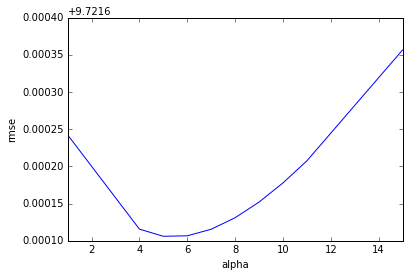

In [30]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

In [31]:
model_ridge = linear_model.Ridge(alpha=6, fit_intercept=True, max_iter=10000)
model_ridge.fit(x_train, y_train)
model_lasso = linear_model.LassoCV(alphas = [1, 0.16, 0.1, 0.001, 0.0005]).fit(x_train, y_train)

In [32]:
rmse_cv(model_lasso).mean()

/home/roman/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


9.7217194633925317

In [33]:
cv_ridge.min()

9.7217060828070796

In [34]:
c = pd.Series(model_lasso.coef_, index = train_set[predictors].columns)
print("Lasso picked " + str(sum(c != 0)) + " variables and eliminated the other " +  str(sum(c == 0)) + " variables")

Lasso picked 50 variables and eliminated the other 25 variables


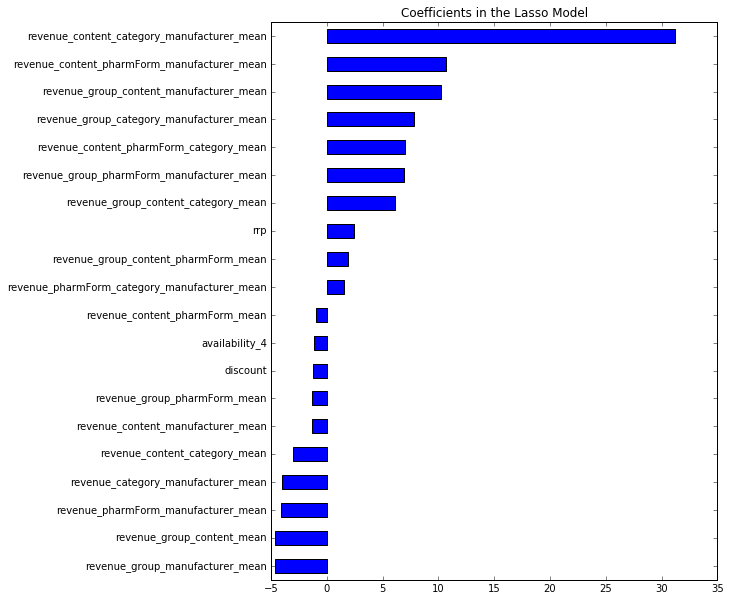

In [35]:
imp_coef = pd.concat([c.sort_values().head(10), c.sort_values().tail(10)])
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

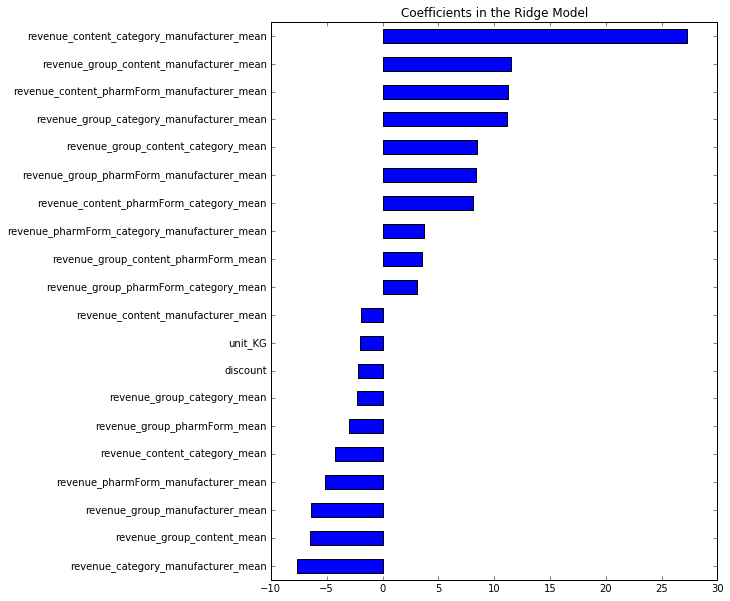

In [36]:
c = pd.Series(model_ridge.coef_, index = train_set[predictors].columns)
imp_coef = pd.concat([c.sort_values().head(10), c.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [37]:
del train_set, x_train, y_train
gc.collect

<function gc.collect>

In [38]:
items = pd.read_csv('data/raw/items.csv',sep='|')
train = pd.read_csv('data/raw/train.csv',sep='|')
train_items=pd.merge(train,items,on='pid')
del train
gc.collect

<function gc.collect>

In [39]:
train_items=toCategorical(train_items)
train_items=solveNA(train_items,train_items,coef_competitorPrice_to_rrp,0)
train_items=Dummies(train_items)
train_items=moreFeautures(train_items)

items = pd.read_csv('data/interim/items_v1.csv')
train_items=pd.merge(train_items,items[items_pred],on='pid')
y_train = train_items['revenue']
x_train = train_items[predictors]

del train_items, items
gc.collect

<function gc.collect>

In [41]:
scaler = MinMaxScaler()
x_train=scaler.fit_transform(x_train)

In [42]:
model_lasso = linear_model.LassoCV(alphas = [1, 0.16, 0.1, 0.001, 0.0005]).fit(x_train, y_train)

In [43]:
model_ridge = linear_model.Ridge(alpha=6, fit_intercept=True, max_iter=10000)
model_ridge.fit(x_train, y_train)

Ridge(alpha=6, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
del y_train,x_train
gc.collect

<function gc.collect>

In [45]:
items = pd.read_csv(
'data/raw/items.csv',sep='|')
clas = pd.read_csv(
'data/raw/class.csv',sep='|')
clas_items=pd.merge(clas,items,on='pid')
clas_items=toCategorical(clas_items)
clas_items=solveNA(clas_items,clas_items,coef_competitorPrice_to_rrp,0)
clas_items=Dummies(clas_items)
clas_items=moreFeautures(clas_items)
items = pd.read_csv(
'data/interim/items_v1.csv')
clas_items=pd.merge(clas_items,items[items_pred],on='pid')

submission = pd.DataFrame({
        "lineID": clas_items["lineID"],
        "revenue": np.zeros(shape=(1210767,))
})

x_test = clas_items[predictors]
del clas_items,clas,items
gc.collect

<function gc.collect>

In [46]:
x_test = x_test.fillna(x_test.mean())
x_test = scaler.fit_transform(x_test)

In [47]:
lasso_preds = model_lasso.predict(x_test)
ridge_preds = model_ridge.predict(x_test)

In [49]:
predictions = pd.DataFrame({"ridge":ridge_preds, "lasso":lasso_preds})
predictions[predictions['ridge']<0]=0
predictions[predictions['lasso']<0]=0

lasso_preds = predictions['lasso']
ridge_preds = predictions['ridge']
com_pred = (lasso_preds + ridge_preds) / 2.0

submission['revenue']=com_pred
submission_sorted=submission.sort_values("lineID");
submission_sorted.to_csv("data/Uni_Polytechnic_Lviv_1.csv", index=False, sep='|')

In [50]:
submission_sorted

,lineID,revenue
0,1,2.918315
314,2,0.085515
688,3,1.153730
1137,4,0.289552
1292,5,1.545264
1779,6,2.567740
1883,7,0.551230
2950,8,1.073107
3333,9,3.508954
3701,10,4.274228
